# Constants

In [2]:
tasks = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
            'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
            'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo','dm1', 'dm2', 'contextdm1', 'contextdm2','multidm']

network_folder = "networks_24/"

# Training

* Trains over all the pairs of tasks and saves each network on a specified directory.


In [ ]:
#alltask trainer
import train
from analysis import performance

import matplotlib.pyplot as plt
import tools
import numpy as np
from task import generate_trials, rule_name, get_dist

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU
os.environ['TF_NUM_INTEROP_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'

import tensorflow as tf

# Configure TF to use single thread
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)


def trainpair(task1,task2,hnodes=32,netfolder="networks/"):
    netname = "_".join(["laconeu",task1,task2,str(hnodes)])
    train.train(model_dir=netfolder+netname, 
            hp={'learning_rate': 0.001, 
                'n_rnn': hnodes,#512, 16384,8192,1024
                # 'w_rec_init': 'randgauss',#'randortho'
                # 'b_rec_init': 'uniform',
                'rule_strength': 1.0,
                'no_rule': False,
                'target_perf':0.8,
                'activation': 'softplus',
                'alpha':0.2},
            ruleset='all',
            rule_trains = [task1,task2],
            trainables='all')#,trainables='bias')


# pair task iteration
counter = 0 
for i in range(len(tasks)):
    for j in range(i+1,len(tasks)):
        if "SLURM_ARRAY_TASK_ID" in os.environ and counter != int(os.environ["SLURM_ARRAY_TASK_ID"]):
            counter+=1
            continue
        print("SLURM_ARRAY_TASK_ID" in os.environ)
        print(counter)
        print(tasks[i],tasks[j])
        counter+=1
        trainpair(tasks[i],tasks[j],hnodes=24,netfolder=network_folder)


# Evaluate

* Evaluates the network on the trained tasks and a noise task
* Saves the results as a dictionary.

* Proposal:
  * Change the dictionary save to indvidual files for each task network

In [ ]:
#pass arbitrary inputs to the trained model
from network import Model
import tensorflow as tf
from task import generate_trials, rule_name, get_dist
import copy
import os

def stimulateTrainedModel(model_dir, n_rep = 16, mode='test'):
    hp = tools.load_hp(model_dir)
    hp_copy = copy.deepcopy(hp)
    hp_copy['rules'].append('random')
    model = Model(model_dir, hp)
    
    output_dict = {rn: None for rn in hp_copy['rules']}
    with tf.Session() as sess:
        model.restore()
        rules_ = copy.deepcopy(hp_copy['rules'])
        for rule_test in rules_:
            batch_size_test_rep = int(hp_copy['batch_size_test']/n_rep)
            rep_mat = {'x':[], 'h':[], 'y_hat':[]}
            for i_rep in range(n_rep):
                # trial = generate_trials(rule, hp, mode='test')
                trial = generate_trials(rule_test, hp_copy, mode, batch_size=batch_size_test_rep, 
                                        rule_strength=hp_copy['rule_strength'], no_rule=hp_copy['no_rule'])
                feed_dict = tools.gen_feed_dict(model, trial, hp_copy)
                x = trial.x
                h, y_hat = sess.run([model.h, model.y_hat], feed_dict=feed_dict)
                
                # x_flat = x.reshape(-1, x.shape[2])
                # h_flat = h.reshape(-1, h.shape[2])
                # y_hat_flat = y_hat.reshape(-1, y_hat.shape[2])

                rep_mat['x'].append(x)
                rep_mat['h'].append(h)
                rep_mat['y_hat'].append(y_hat)
                
            
            # for key in rep_mat.keys():
            #     rep_mat[key] = np.concatenate(rep_mat[key])
            output_dict[rule_test] = rep_mat
                
    return output_dict

all_mods = {}
for model_dir in os.listdir('../networks_24/'):
    output_dict = stimulateTrainedModel(model_dir, n_rep=4, mode='test')
    all_mods[model_dir] = output_dict

#save the stimulation results for each model
np.save('mods_24_all.npy', all_mods)


# HOI computations


In [ ]:
import thoi
from thoi.measures.gaussian_copula import multi_order_measures, nplets_measures
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import os
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


model_dirs = os.listdir("networks_24/")

out = np.load('eval_24.npy', allow_pickle=True).item()
out.keys()

# join and organize the data
alldata = {}
for model in model_dirs:
    modelh = {}
    for task in out[model].keys():
        #print(f'{model}_{task}')
        hlist = []
        for i in range(4):
            hmat = out[model][task]['h'][i]
            hjoinmatrix = np.swapaxes(hmat[:,:,:],0,1).reshape(-1,hmat.shape[-1]).T
            hlist.append(hjoinmatrix)
        allh = np.concatenate(hlist, axis=1)
        #print(task, allh.shape)
        modelh[task] = allh
    alldata[model] = modelh
shorterlength = min([alldata[model][task].shape[1] for model in model_dirs for task in alldata[model].keys()])


all_meanhoi = []

for model in model_dirs:
    for task in alldata[model].keys():
        print(model, task, alldata[model][task].shape)
        htensor = torch.tensor(alldata[model][task].T, dtype=torch.float32, device='cuda')
        hoidata = multi_order_measures(alldata[model][task][:,:shorterlength].T, min_order=3, max_order=6)
        meanhoi = hoidata.groupby('order').mean()[["o", "s", "tc", "dtc"]]
        # Add model and task columns
        meanhoi['model'] = model
        meanhoi['task'] = task
        all_meanhoi.append(meanhoi)

# Concatenate all meanhoi dataframes
concatenated_meanhoi = pd.concat(all_meanhoi)
#save the concat dataframe
concatenated_meanhoi = concatenated_meanhoi.reset_index()
concatenated_meanhoi.to_csv('concatenated_meanhoi_trimmed_24_3_6.csv')

# FTV - Fractional Task Variance

In [ ]:
#Variance
from analysis.variance import compute_hist_varprop,compute_variance
import os 
for modeldir in os.listdir(network_folder):
    modelrules = modeldir.split('_')[1:3]
    modelpath = os.path.abspath(network_folder+modeldir)
    compute_variance(modelpath, rules=modelrules)

In [3]:
#Load all the variances and save them in a single dataframe
import pickle
import pandas as pd
import numpy as np
import os

modeldirs = os.listdir(network_folder)
allvariances = []
for modeldir in modeldirs:
    #pickle load variance_rule.pkl
    with open(network_folder+modeldir+'/variance_rule.pkl', 'rb') as f:
        var_dict = pickle.load(f)
        h_var_all = var_dict["h_var_all"]
        taskvariance = (h_var_all[:, 0]-h_var_all[:, 1])/((h_var_all[:, 0]+h_var_all[:, 1]))
        allvariances.append(taskvariance)

#create variances dataframe
allvariances = np.array(allvariances)
allvariancesdf = pd.DataFrame(allvariances, columns=[f"n{i}" for i in range(allvariances.shape[1])])
allvariancesdf["model"] = modeldirs
allvariancesdf["task1"] = [modeldir.split('_')[1] for modeldir in modeldirs]
allvariancesdf["task2"] = [modeldir.split('_')[2] for modeldir in modeldirs]
allvariancesdf.to_csv('allvariances_24.csv')

In [2]:
#how much variance does the pca explain
#print(pca.explained_variance_ratio_)
import numpy as np
from scipy.stats import gaussian_kde

def differential_entropy(data):
    # Estimate the density using Gaussian KDE
    kde = gaussian_kde(data)
    
    # Define the range of values where the PDF will be evaluated
    x = np.linspace(min(data), max(data), 1000)
    
    # Evaluate the KDE to get the PDF values
    pdf = kde(x)
    
    # Compute the differential entropy
    entropy = -np.sum(pdf * np.log(pdf)) * (x[1] - x[0])
    
    
    return entropy


In [21]:
#make a pca projection plot of allvariances n columns
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(allvariances)
allvariancesdf['pca-one'] = pca_result[:,0]
allvariancesdf['pca-two'] = pca_result[:,1]


In [4]:
allvariancesdf["difentropy"] = allvariancesdf[[f"n{i}" for i in range(allvariances.shape[1])]].apply(lambda x: differential_entropy(x), axis=1)


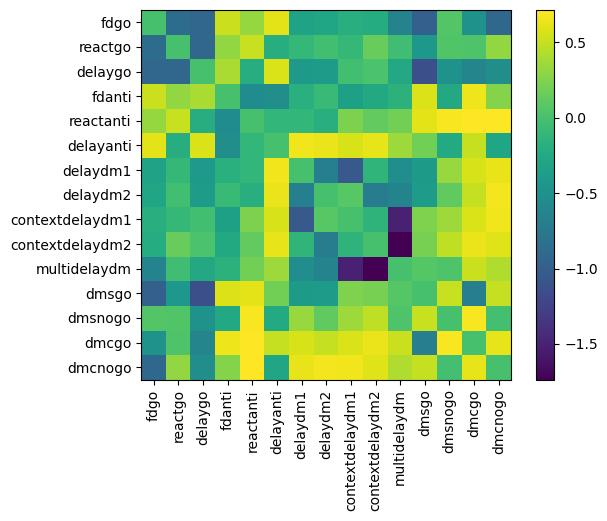

In [ ]:
import matplotlib.pyplot as plt
difarray = np.zeros((len(tasks),len(tasks)))
for i in range(len(tasks)):
    for j in range(i+1,len(tasks)):
        #the difentropy of the taski and taskj
        difarray[i,j] = allvariancesdf[(allvariancesdf["task1"]==tasks[i]) & (allvariancesdf["task2"]==tasks[j])]["difentropy"].values[0]
        difarray[j,i] = difarray[i,j]
#add task names as labels
plt.xticks(range(len(tasks)), tasks, rotation=90)
plt.yticks(range(len(tasks)), tasks)
plt.imshow(difarray)
plt.colorbar()


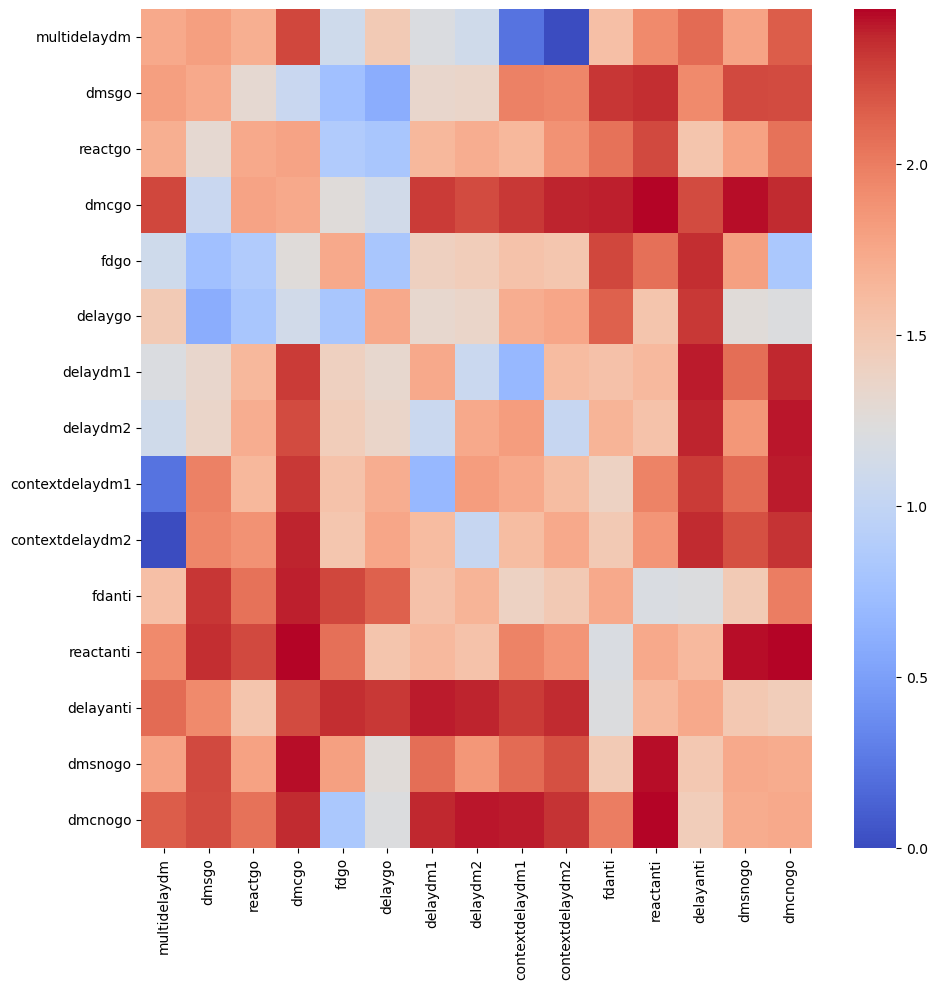

In [17]:
from scipy.cluster.hierarchy import linkage, leaves_list
import seaborn as sns

import matplotlib.pyplot as plt

# Compute linkage matrix for hierarchical clustering
linkage_matrix = linkage(difarray, method='average', metric='cosine')

# Get the leaf order
leaf_order = leaves_list(linkage_matrix)

# Reorder the difarray using the leaf order
reordered_difarray = difarray[leaf_order][:,leaf_order]
reordered_tasks = [tasks[i] for i in leaf_order]

# Create heatmap with reordered data
plt.figure(figsize=(10,10))
sns.heatmap(reordered_difarray, 
            xticklabels=reordered_tasks, 
            yticklabels=reordered_tasks,
            cmap='coolwarm')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans

# Choose number of clusters that maximize silhouette score
n_clusters = range(2, 30)
scores = list()
labels_list = list()
for n_cluster in n_clusters:
    # clustering = AgglomerativeClustering(n_cluster, affinity='cosine', linkage='average')
    #clustering = KMeans(n_cluster, algorithm='full', n_init=20, random_state=0)
    #clustering = AgglomerativeClustering(n_clusters=n_cluster, affinity='cosine', linkage='average')
    clustering.fit(allvariances) # n_samples, n_features = n_units, n_rules/nepochs
    # Alternative clustering method: Agglomerative Clustering
    labels = clustering.labels_ # cluster labels
    score = metrics.silhouette_score(allvariances, labels)
    scores.append(score)
    labels_list.append(labels)

scores = np.array(scores)
#penalize by number of clusters
lam = 0.1
pen_scores = scores - np.log(n_clusters)*lam

/filer/users/iampuero/conda/envs/rnn/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/filer/users/iampuero/conda/envs/rnn/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/filer/users/iampuero/conda/envs/rnn/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/filer/users/iampuero/conda/envs/rnn/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/filer/users/iampuero/conda/envs/rnn/lib/python3.9/s

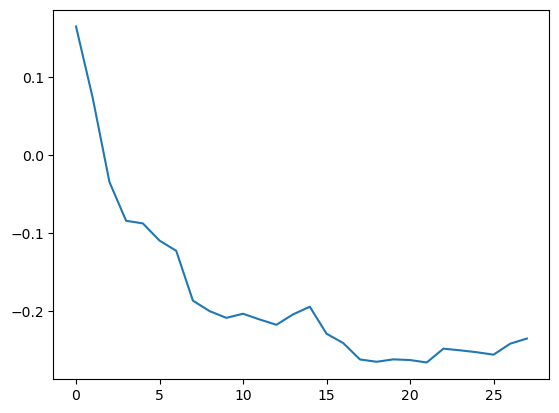

In [15]:
import matplotlib.pyplot as plt
plt.plot(pen_scores)

# Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#load concatenated dataframe
concatenated_meanhoi = pd.read_csv('concatenated_meanhoi_all_24.csv')
#add task1 and task2 columns 
concatenated_meanhoi['task1'] = concatenated_meanhoi['model'].apply(lambda x: x.split('_')[1])
concatenated_meanhoi['task2'] = concatenated_meanhoi['model'].apply(lambda x: x.split('_')[2])

In [2]:
concatenated_meanhoi[concatenated_meanhoi["order"]==3]

,order,o,s,tc,dtc,model,task,task1,task2
0,3,-0.015200,0.712118,0.348459,0.363659,laconeu_dmsgo_contextdm2_24,contextdm2,dmsgo,contextdm2
6,3,-0.062445,1.540023,0.738789,0.801234,laconeu_reactgo_delaygo_24,delaygo,reactgo,delaygo
12,3,0.075256,1.231131,0.653194,0.577937,laconeu_dmsgo_dmcgo_24,dmcgo,dmsgo,dmcgo
18,3,-0.014517,0.761647,0.373565,0.388082,laconeu_dm2_multidm_24,dm2,dm2,multidm
24,3,0.034742,1.457870,0.746306,0.711564,laconeu_contextdelaydm1_dmsnogo_24,random,contextdelaydm1,dmsnogo
...,...,...,...,...,...,...,...,...,...
3390,3,-0.009162,0.568080,0.279459,0.288621,laconeu_delaydm2_dm2_24,delaydm2,delaydm2,dm2
3396,3,0.004418,0.571213,0.287816,0.283398,laconeu_reactgo_multidm_24,reactgo,reactgo,multidm
3402,3,0.053148,0.677311,0.365230,0.312082,laconeu_fdgo_contextdelaydm1_24,random,fdgo,contextdelaydm1
3408,3,0.035177,0.759967,0.397572,0.362395,laconeu_fdgo_dmsgo_24,random,fdgo,dmsgo


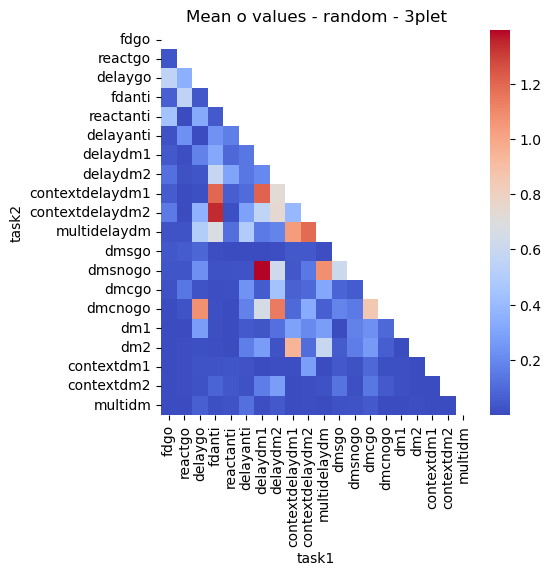

In [5]:
# single heatmap example with random and order 3

subselect_meanhoi = concatenated_meanhoi[(concatenated_meanhoi['order'] == 3) & (concatenated_meanhoi['task'] == 'random')]
# Create a pivot table with tasks list as the order reference
pivot_table = subselect_meanhoi.pivot(index='task2', columns='task1', values='o').reindex(index=tasks, columns=tasks)

plt.figure(figsize=(5, 5))
sns.heatmap(pivot_table, cmap='coolwarm')#, cbar_kws={'label': 'o'}), annot=True
plt.title('Mean o values - random - 3plet')
plt.show()


In [6]:
concatenated_meanhoi.task.unique()

array(['contextdm2', 'delaygo', 'dmcgo', 'dm2', 'random', 'fdanti', 'dm1',
       'reactanti', 'reactgo', 'dmsgo', 'multidelaydm', 'contextdelaydm2',
       'delaydm1', 'contextdelaydm1', 'dmsnogo', 'contextdm1', 'dmcnogo',
       'fdgo', 'multidm', 'delaydm2', 'delayanti'], dtype=object)

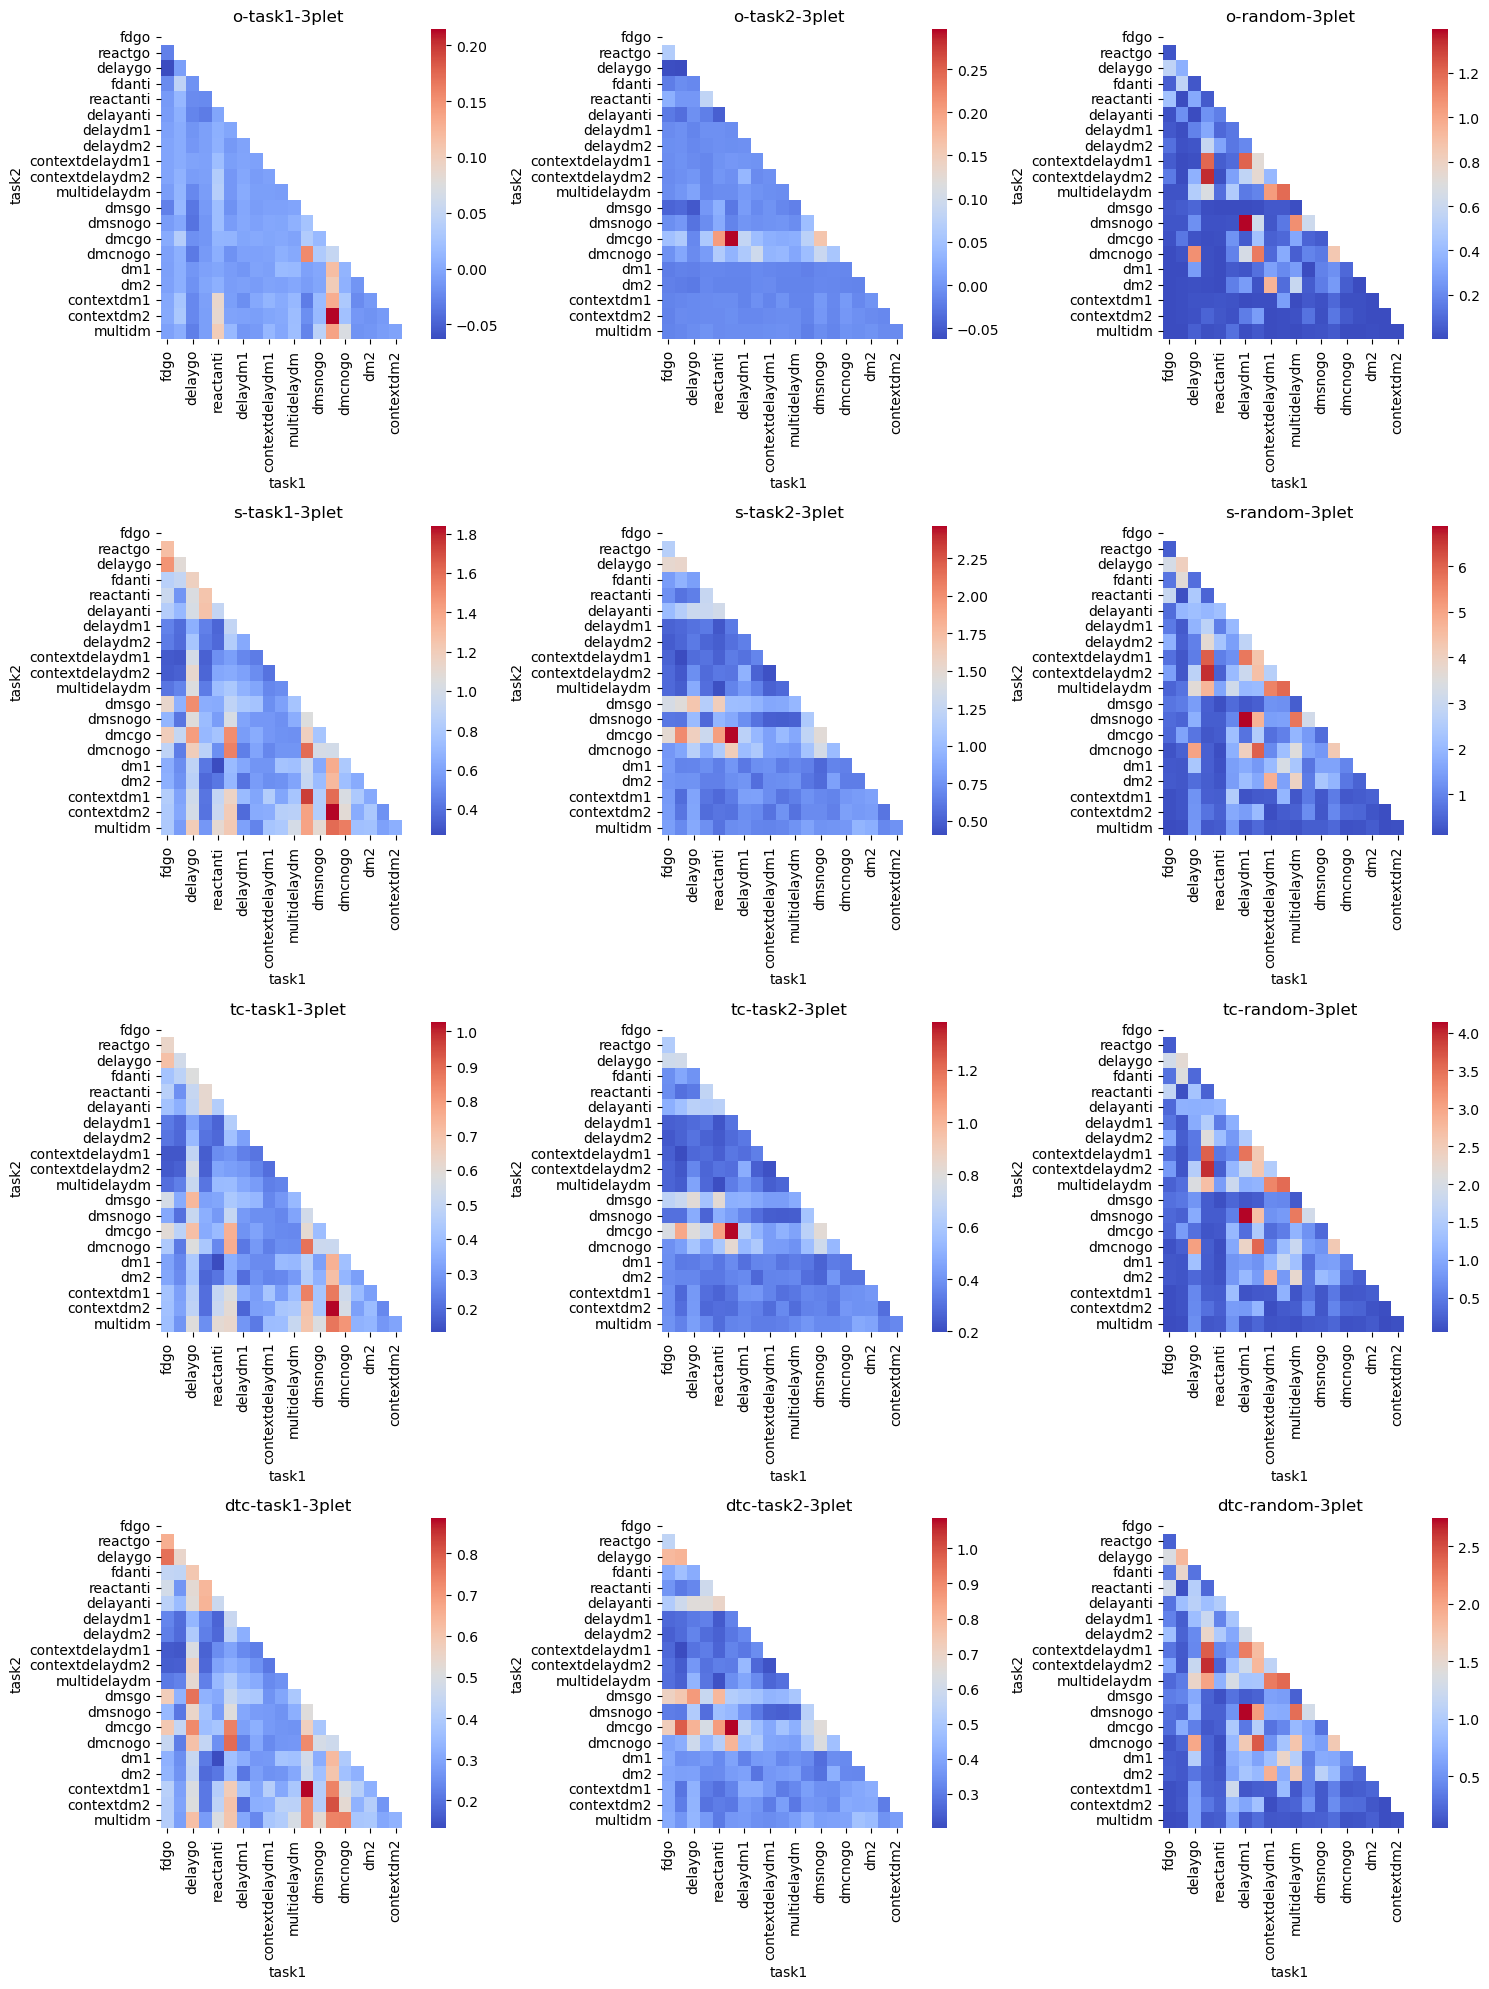

In [7]:

fig,axes = plt.subplots(4,3,figsize=(15,20))
axes = axes.flatten()
axcounter = 0
for metricind,metric in enumerate(["o","s","tc","dtc"]):
    for taskind,task in enumerate(["task1","task2","random"]):
        if task == "random":
            subselect_meanhoi = concatenated_meanhoi[(concatenated_meanhoi['order'] == 3) & (concatenated_meanhoi['task'] == 'random')]
        else:
            subselect_meanhoi = concatenated_meanhoi[(concatenated_meanhoi['order'] == 3) & (concatenated_meanhoi['task'] == concatenated_meanhoi[task])]
        pivot_table = subselect_meanhoi.pivot(index='task2', columns='task1', values=metric).reindex(index=tasks, columns=tasks)        
        sns.heatmap(pivot_table, cmap='coolwarm',ax=axes[axcounter] )#, cbar_kws={'label': 'o'}), annot=True
        axes[axcounter].set_title(f'{metric}-{task}-3plet')
        axcounter+=1
plt.tight_layout()
plt.show()


# SANDBOX ZONE

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

allcropped = np.load('mods_24_all_cropped.npy', allow_pickle=True).item()
exmodelname = 'laconeu_reactgo_dm1_24'
task1 = exmodelname.split('_')[1]
task2 = exmodelname.split('_')[2]
extask = "dm1"
exhidden = allcropped[exmodelname][extask]
exhois = pd.read_csv('hois_24/'+exmodelname+'_'+extask+'_8.csv.zip')


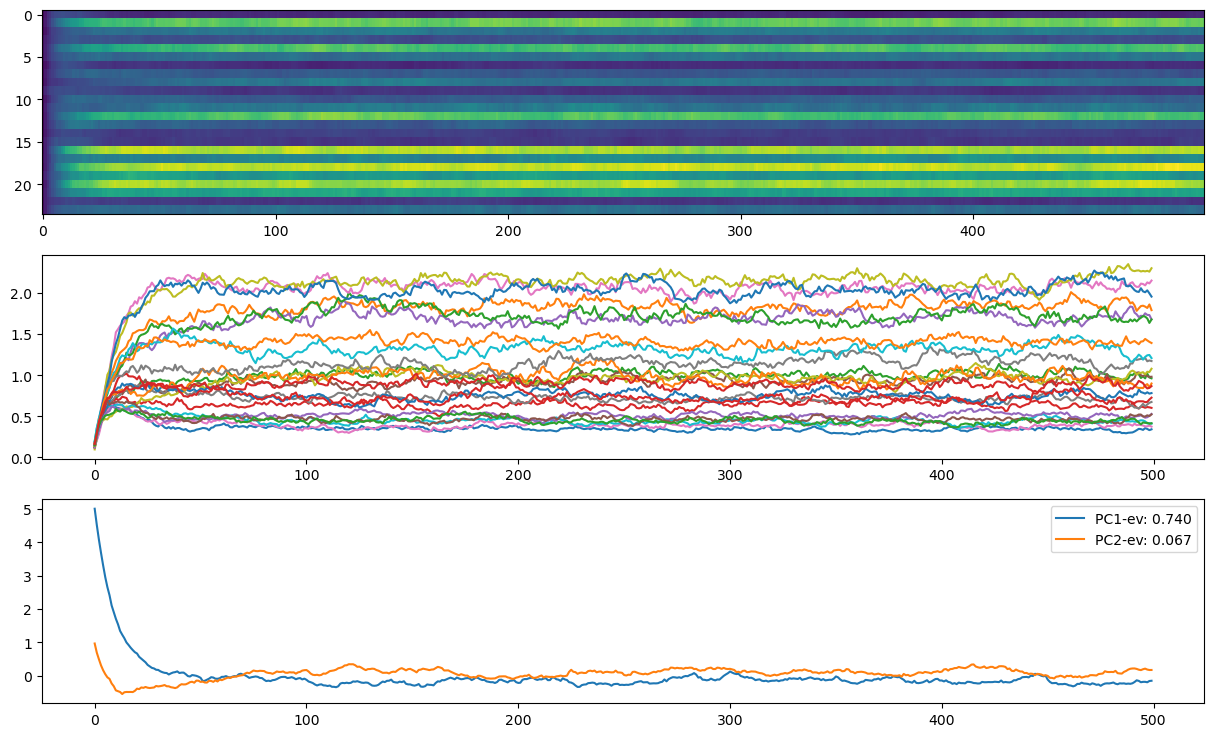

In [61]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(exhidden.T)
tmin = 0
tlim = 500
fig,ax  = plt.subplots(3,1,figsize=(15,9))
ax[0].imshow(exhidden[:,tmin:tlim],aspect="auto",interpolation="none")
ax[1].plot(exhidden[:,tmin:tlim].T)
ax[2].plot(range(tlim-tmin), pca_result[tmin:tlim,0], label=f"PC1-ev: {pca.explained_variance_ratio_[0]:.3f}")
ax[2].plot(range(tlim-tmin), pca_result[tmin:tlim,1], label=f"PC2-ev: {pca.explained_variance_ratio_[1]:.3f}")
ax[2].legend()
plt.show()

In [50]:
#model perf check
import os
import json

for model in os.listdir(network_folder):
    with open(network_folder+model+'/log.json', 'r') as f:
        logs = json.load(f)
        rule1 = model.split('_')[1]
        rule2 = model.split('_')[2]
        length = len(logs["perf_"+rule1])
        if logs["perf_"+rule1][-1] < 0.8 or logs["perf_"+rule2][-1] < 0.8:
            print(model,"not well trained")


In [5]:
import pandas as pd

# Suppose df has data columns [col_a, col_b, col_c] and indicator columns [var_0 ... var_17].
means_list = []
metrics = ["tc","dtc","o","s"]
for i in range(24):
    var_col = f"var_{i}"
    filtered = exhois[exhois[var_col] == True]  # or == 1
    grouped_means = filtered.groupby("order")[metrics].mean().reset_index()
    grouped_means["node"] = i
    means_list.append(grouped_means)
    
pernodedf = pd.concat(means_list, ignore_index=True)

In [14]:
pernodedf

,order,tc,dtc,o,s,var_col
0,3,0.198829,0.208591,-0.009762,0.407420,var_0
1,4,0.495738,0.544944,-0.049206,1.040682,var_0
2,5,0.946458,1.077414,-0.130956,2.023872,var_0
3,6,1.557684,1.798661,-0.240977,3.356345,var_0
4,7,2.323450,2.655993,-0.332544,4.979443,var_0
...,...,...,...,...,...,...
139,4,0.673024,0.750534,-0.077510,1.423559,var_23
140,5,1.178801,1.333098,-0.154297,2.511899,var_23
141,6,1.827350,2.046422,-0.219072,3.873773,var_23
142,7,2.610531,2.850368,-0.239837,5.460898,var_23


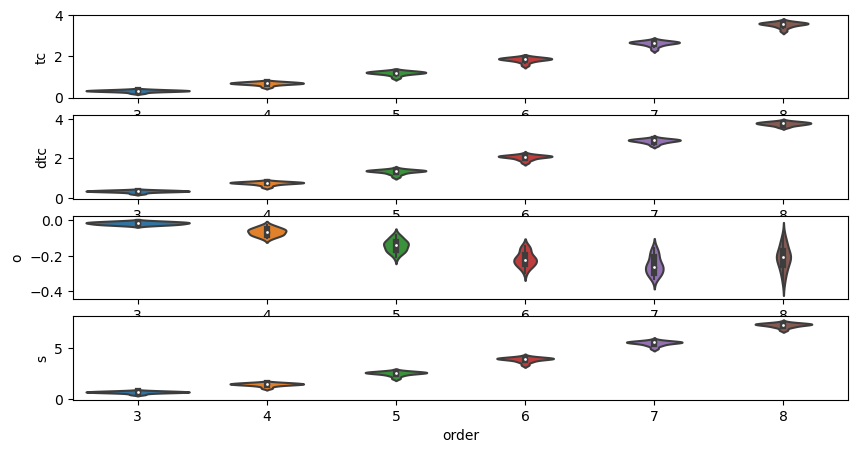

In [13]:
#plot the o metric for each order and each var
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 1, figsize=(10, 5))
for i, metric in enumerate(metrics):
    #sns.lineplot(data=pernodedf, x="order", y=metric, hue="var_col", ax=ax[i])
    sns.violinplot(data=pernodedf, x="order", y=metric, ax=ax[i])
    #disable legend
    #ax[i].get_legend().remove()
